In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from py2neo import Graph, authenticate, Relationship
from sklearn import preprocessing
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm, datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron as PPN
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
data = pd.DataFrame.from_csv("PS_20174392719_1491204439457_log.csv", index_col=None)

In [3]:
data = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                            'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest          object
oldBalanceDest    float64
newBalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Sample Data 

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

In [6]:
# First day 
df_day = data[data.step.isin(range(24))]

# Data Vizualisation

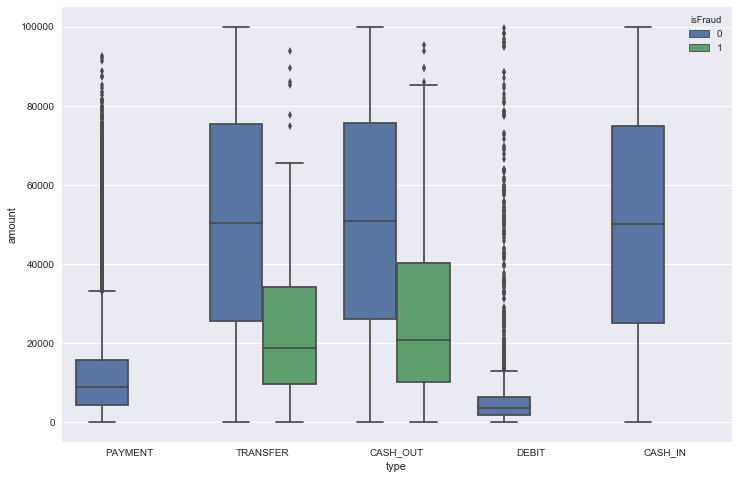

In [7]:
plt.figure(figsize=(12,8))
sns.boxplot(hue = 'isFraud', x = 'type', y = 'amount', data = df_day[df_day.amount < 1e5])

In [8]:
df_day[df_day.isFraud==1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

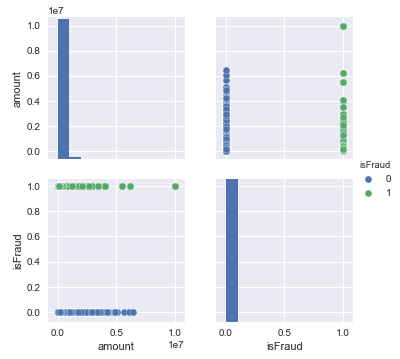

In [9]:
plt.figure(figsize=(20,5))
sns.pairplot(df_day[['amount','isFraud'][:1000]], hue='isFraud')
# rajouter les colonnes isCustomer, couldBeFraud ...

* Really few fraud -> efficiency for supervised learning
* Mostly small amounts -> interest of isFlaggedFraud variable ?

# Feature engineering

## Categorical variables : 
    - Not to much different values
    - equilibrium between occurences 
    - making groups based on frequenies or buisness logic ?

### Types

In [10]:
uniqueType = list(set(df_day.type.unique()))
print uniqueType

['CASH_OUT', 'TRANSFER', 'PAYMENT', 'CASH_IN', 'DEBIT']


In [11]:
pd.options.mode.chained_assignment = None 
df_day["typeAsNumeric"] = [uniqueType.index(v) for v in df_day["type"]]

### names

In [12]:
df_sample = df_day.sample(n=10000)
print len(set(df_sample.nameOrig.unique()))
print len(set(df_sample.nameDest.unique()))

# Because of anonymization, names are mostly differents.

10000
9347


In [13]:
df_sample.nameDest[:5]

127202    C1770777928
275041     C574856178
243723    C1875623471
438585     M903450904
143266    C1343108348
Name: nameDest, dtype: object

In [14]:
# Owners are costumers or merchants
names = [name[0] for name in df_day["nameOrig"]]
costumersOrig = [int(n=="C") for n in names]
df_day["origIsCustomer"] = costumersOrig

names = [name[0] for name in df_day["nameDest"]]
costumersDest = [int(n=="C") for n in names]
df_day["destIsCustomer"] = costumersDest

### is Fraud
Fraudulent data are artificialy built, always in the same way : 
    - take the control of an account 
    - transfer to an other account
    - cash out
Actions : 
*              (Account A) -[TRANSFER] -> (Account B)
*              (Account B) - CASH_OUT

-> Use case for neo4j ?

### Because of anonymization, names are not usefull to follow money path. 

Just for playing : create link  

In [15]:
names = [name[:4] for name in df_day["nameOrig"]]
df_day["fakeNameOrig"] = names

names = [name[:4] for name in df_day["nameDest"]]
df_day["fakeNameDest"] = names

In [16]:
df_day.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,typeAsNumeric,origIsCustomer,destIsCustomer,fakeNameOrig,fakeNameDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,2,1,0,C123,M197
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,2,1,0,C166,M204
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1,C130,C553
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,1,C840,C389
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,2,1,0,C204,M123


In [ ]:
df_day.to_csv("C:\\Users\\thaunayf\\Documents\Neo4j\\DC10_3\\import\\day1.csv")

In [ ]:
for i in range(24) :
    df_hour = df_day[day_df.step.isin(range(i,i+1))]
    df_hour.to_csv("C:\\Users\\thaunayf\\Documents\Neo4j\\DC10_3\\import\\hour"+str(i)+".csv", header=True)

In [17]:
graph = Graph(user="neo4j", password="admin")

In [18]:
a = graph.run('''
MATCH p= (a)-[action:RELTYPE{type:"TRANSFER"}]->(b)
RETURN b.Name
''').data()
print a[:5]

[{u'b.Name': u'C885'}, {u'b.Name': u'C885'}, {u'b.Name': u'C885'}, {u'b.Name': u'C885'}, {u'b.Name': u'C885'}]


In [19]:
b = graph.run('''
MATCH p= (a)-[action:RELTYPE{type:"CASH_OUT"}]->(b)
RETURN a.Name
''').data()
print b[:5]

[{u'a.Name': u'C664'}, {u'a.Name': u'C153'}, {u'a.Name': u'C122'}, {u'a.Name': u'C107'}, {u'a.Name': u'C654'}]


In [20]:
# 'C123' at row 1 
graph.run('''
MATCH p=shortestPath((a:Account { Name: 'C123' })-[r *..6]-(b: Account))
with length(p) as sp, b
return b.Name, sp
ORDER BY sp DESC LIMIT 2
''').data()

[{u'b.Name': u'M541', u'sp': 2}, {u'b.Name': u'C666', u'sp': 2}]

### Real case : Follow money


In [ ]:
# amounts = df.amount.unique().tolist()
# a = []
# for amount in amounts :
#     a.append(graph.run('''
# MATCH p= ()-[r1:RELTYPE{type:"TRANSFER"}]->(),  q= ()-[r2:RELTYPE{type:"CASH_OUT"}]->()
# WHERE r1.amount = $AMOUNT AND r2.amount = $AMOUNT AND r2.step >= r1.step
# RETURN p, q, r1.dataLine AS row1, r2.dataLine as row2
# ''',{'AMOUNT': amount}).data())

SQL request, too long with graph Database => do it with DataFrame

In [21]:
df_transfer = df_day[df_day.type=="TRANSFER"]
df_cash_out = df_day[df_day.type=="CASH_OUT"]
amounts = df_day[df_day.type.isin(["TRANSFER", "CASH_OUT"])].amount.unique().tolist()

followMoney = []

for amount in amounts :
    df_transfer_amount = df_transfer[df_transfer.amount==amount]
    df_cash_out_amount = df_cash_out[df_cash_out.amount==amount]

    for i, row in df_transfer_amount.iterrows() :
        for j, row2 in df_cash_out_amount.iterrows() :
            if (row["step"] == row2["step"]) :
                followMoney.append(i)
                followMoney.append(j)

df_day["followMoney"] = np.zeros(len(df_day))
for b in followMoney :
    df_day.at[b, 'followMoney'] = 1


### isFlaggedFraud 

In [22]:
df_day.mean()

step              1.477482e+01
amount            1.606540e+05
oldBalanceOrig    8.928001e+05
newBalanceOrig    9.124600e+05
oldBalanceDest    9.729585e+05
newBalanceDest    1.139378e+06
isFraud           4.640664e-04
isFlaggedFraud    0.000000e+00
typeAsNumeric     1.436651e+00
origIsCustomer    1.000000e+00
destIsCustomer    6.621089e-01
followMoney       4.640664e-04
dtype: float64

In [23]:
# isFlaggedFraud : The business model aims to control massive transfers from one account to another and flags illegal
# attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction


print "Minimum amount in a flagged Fraud transaction : {0:.1f}".format(min((data.ix[data["isFlaggedFraud"]==1].amount.tolist())))
print "All transactions flagged Fraud have amount > 200 000 \n"
print  "Maximum amount in a not flagged Fraud transaction : {0:.1f}".format(max(data.ix[data["isFlaggedFraud"]==0].amount.tolist()))
print "Not all amounts > 200 000 are flagged Fraud"
a = data.ix[data["isFlaggedFraud"]==0].amount.tolist()
b = [t for t in a if t > 200000]
print  "For amount > 2000 000, {0:.1f} are flagged Fraud and {1:.1f} are not \n".format((len(b)),(len(df_day.ix[df_day["isFlaggedFraud"]==1].amount.tolist())))
print " --> Don't use this feature"



Minimum amount in a flagged Fraud transaction : 353874.2
All transactions flagged Fraud have amount > 200 000 

Maximum amount in a not flagged Fraud transaction : 92445516.6
Not all amounts > 200 000 are flagged Fraud
For amount > 2000 000, 1673554.0 are flagged Fraud and 0.0 are not 

 --> Don't use this feature


### Amounts as categories

In [24]:
amounts = df_day.amount.tolist()
ave_amounts = [int(np.log10(amount)*10) for amount in amounts]
df_day["categorized_amount"] = ave_amounts

### Additional feature : errors in data

In [25]:
df_nonFraud = df_day.loc[(df_day.isFraud == 0)]
df_fraud = df_day.loc[(df_day.isFraud == 1)]

In [26]:
errorInOrig, errorInDest, errorInTransfer = 0, 0, 0
for i,row in df_nonFraud.iterrows():
   
    if (abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1):
        errorInOrig +=1
    if(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)  :
        errorInDest +=1
    if(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 & row["destIsCustomer"] == 1) :
        errorInTransfer +=1
        
print  "Error in percents : \n "
print " - If genuine : \n"
print "     Origin - Amount: {0:.1f}, Destination - Amount: {1:.1f}, Origin - Destination  {2:.1f}  \n".format((float(errorInOrig)/len(df_nonFraud)),(float(errorInDest)/len(df_nonFraud)), (float(errorInTransfer)/len(df_nonFraud)))

errorInOrig, errorInDest, errorInTransfer = 0, 0, 0
for i,row in df_fraud.iterrows():
   
    if (abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1):
        errorInOrig +=1
    if(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)  :
        errorInDest +=1
    if(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 & row["destIsCustomer"] == 1) :
        errorInTransfer +=1

print " - If fraud : \n"
print "     Origin - Amount: {0:.1f}, Destination - Amount: {1:.1f}, Origin - Destination  {2:.1f}  \n".format((float(errorInOrig)/len(df_fraud)),(float(errorInDest)/len(df_fraud)), (float(errorInTransfer)/len(df_fraud)))


Error in percents : 
 
 - If genuine : 

     Origin - Amount: 0.8, Destination - Amount: 0.4, Origin - Destination  0.5  

 - If fraud : 

     Origin - Amount: 0.1, Destination - Amount: 0.7, Origin - Destination  0.8  



In [27]:
df_day["errorInOrig"], df_day["errorInDest"], df_day["errorInDest"] = \
                        np.zeros(len(df_day)), np.zeros(len(df_day)), np.zeros(len(df_day))

for i,row in df_nonFraud.iterrows():

    df_day["errorInOrig"][i]=(abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1)
    df_day["errorInDest"][i]=(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)
    df_day["errorInDest"][i]=(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 
                            & row["destIsCustomer"] == 1)
for i,row in df_fraud.iterrows():

    df_day["errorInOrig"][i]=(abs(row["amount"] - (row.oldBalanceOrig - row.newBalanceOrig)) > 1)
    df_day["errorInDest"][i]=(abs(row["amount"] - (row.newBalanceDest - row.oldBalanceDest)) > 1  & row["destIsCustomer"] == 1)
    df_day["errorInDest"][i]=(abs((row.oldBalanceOrig - row.newBalanceOrig) - (row.newBalanceDest - row.oldBalanceDest)) > 1 
                            & row["destIsCustomer"] == 1)

## Save DataFrame 

In [28]:
df_day.to_csv("df_day.csv")

In [3]:
df_day = pd.DataFrame.from_csv("day_df.csv", index_col=None)

In [29]:
df_day.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,typeAsNumeric,origIsCustomer,destIsCustomer,fakeNameOrig,fakeNameDest,followMoney,categorized_amount,errorInOrig,errorInDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,2,1,0,C123,M197,0.0,39,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,2,1,0,C166,M204,0.0,32,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1,1,C130,C553,1.0,22,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,1,C840,C389,1.0,22,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,2,1,0,C204,M123,0.0,40,0.0,0.0


In [30]:
df_day.columns

Index([u'step', u'type', u'amount', u'nameOrig', u'oldBalanceOrig',
       u'newBalanceOrig', u'nameDest', u'oldBalanceDest', u'newBalanceDest',
       u'isFraud', u'isFlaggedFraud', u'typeAsNumeric', u'origIsCustomer',
       u'destIsCustomer', u'fakeNameOrig', u'fakeNameDest', u'followMoney',
       u'categorized_amount', u'errorInOrig', u'errorInDest'],
      dtype='object')

In [31]:
df_day[[u'step', u'amount', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest', u'isFraud',
        u'typeAsNumeric', u'origIsCustomer', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']]

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,typeAsNumeric,origIsCustomer,destIsCustomer,followMoney,errorInOrig,errorInDest,categorized_amount
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,2,1,0,0.0,0.0,0.0,39
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,2,1,0,0.0,0.0,0.0,32
2,1,181.00,181.00,0.00,0.00,0.00,1,1,1,1,1.0,0.0,1.0,22
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,1,1,1.0,0.0,1.0,22
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,2,1,0,0.0,0.0,0.0,40
5,1,7817.71,53860.00,46042.29,0.00,0.00,0,2,1,0,0.0,0.0,0.0,38
6,1,7107.77,183195.00,176087.23,0.00,0.00,0,2,1,0,0.0,0.0,0.0,38
7,1,7861.64,176087.23,168225.59,0.00,0.00,0,2,1,0,0.0,0.0,0.0,38
8,1,4024.36,2671.00,0.00,0.00,0.00,0,2,1,0,0.0,1.0,0.0,36
9,1,5337.77,41720.00,36382.23,41898.00,40348.79,0,4,1,1,0.0,0.0,1.0,37


# Supervised learning

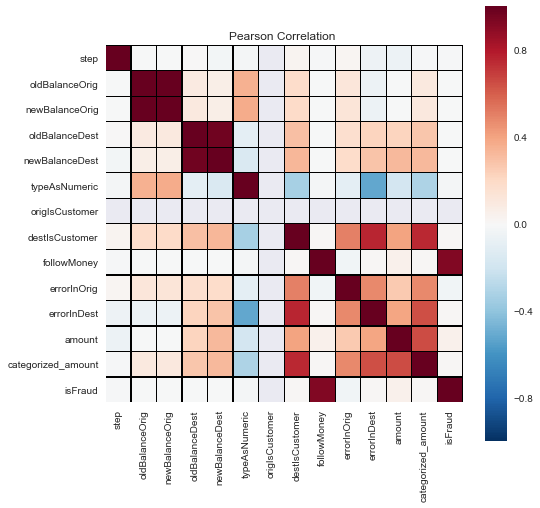

In [7]:

# Set up the matplotlib figure
g, ax2 = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation ')
# Draw the heatmap using seaborn
sns.heatmap(df_day[[u'step', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest', 
        u'typeAsNumeric', u'origIsCustomer', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest', u'amount',
        u'categorized_amount', u'isFraud',]].astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')


* Strong correlation between old and new Balance : probably because of null or non updated values 
* We already see that followMoney will be "the" important feature
* origIsCustomer -> always the case

In [32]:
X = np.array(df_day[[u'step', u'amount', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest',
        u'typeAsNumeric', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']])
X_scaled = preprocessing.scale(X)

In [33]:
y = np.array(df_day[["isFraud"]])
y2 = np.array([v[0] for v in y])

### feature selection

Feature ranking:
1. followMoney (0.663534)
2. newBalanceOrig (0.111420)
3. errorInOrig (0.087091)
4. amount (0.030335)
5. oldBalanceOrig (0.025119)
6. newBalanceDest (0.017538)
7. oldBalanceDest (0.012181)
8. typeAsNumeric (0.011502)
9. step (0.008363)
10. destIsCustomer (0.000835)


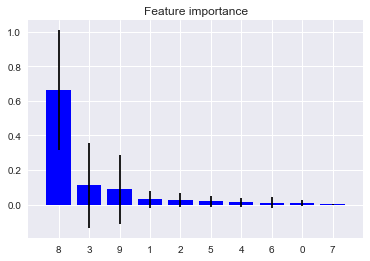

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y2, random_state=0)
#RF : RandomForestClassifier
forest = RF(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
forest_fit = forest.fit(X_train, y_train)
forest_prediction = forest_fit.predict(X_test)

# renvoie un array avec les importances relatives des 10 premieres caracteristiques
importances = forest_fit.feature_importances_[:10]

# numpy.std : Returns the standard deviation, a measure of the spread of a distribution
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# Renvoie un tableau des indices dans l'ordre où ils seraient après un tri
indices = np.argsort(importances)[::-1]

columns = [u'step', u'amount', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest',
        u'typeAsNumeric', u'destIsCustomer', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']
#Print the feature ranking
print("Feature ranking:")
features = [x for y, x in sorted(zip(importances,columns), reverse=True)]

for f in range(10):
    print("%d. %s (%f)" % (f+1, features[f], importances[indices[f]]))
    
#plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices], yerr=std[indices], color="b", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1,10])
plt.show()

### Remove note usefull features

In [35]:
X = np.array(df_day[[u'amount', u'oldBalanceOrig', u'newBalanceOrig', u'oldBalanceDest', u'newBalanceDest',
        u'typeAsNumeric', u'followMoney', u'errorInOrig', u'errorInDest',
        u'categorized_amount']])
X_scaled = preprocessing.scale(X)

- Accuracy = (TP + TN) / Total
- Presicion = TP / (TP + FP)
- Recall = TP / (TP + FN)

Most interesting indicator should be the recall score to capture the most fraudulent transactions. 

In [36]:
def recall_score(y_true, y_pred, labels=None, pos_label=1, average="binary", sample_weight=None):
    return recall_score(y_true, y_pred)

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(n_splits=3)
    y_pred = y.copy()
  
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [37]:
X_sample = X_scaled[:100000]
y_sample = y2[:100000]

In [38]:
from sklearn.metrics import recall_score
# Test different models
models = ["Logistic Regression:", "Gradient Boosting Classifier", "Support vector machines:",
          "Random forest:","K-nearest-neighbors:"]
algos = [LR, GBC, SVC, RF, KNN]

for i, row in enumerate(models):
    from sklearn.metrics import f1_score
    print models[i]
    y_pred = run_cv(X_sample,y_sample,algos[i])
    f1_score = f1_score(y_sample, y_pred, average=None)
    print "Accuracy: {0:0.2f} and recall : {1:0.2f}\n".format(f1_score[0], f1_score[1])

   
     

Logistic Regression:
Accuracy: 1.00 and recall : 0.96

Gradient Boosting Classifier
Accuracy: 1.00 and recall : 0.92

Support vector machines:
Accuracy: 1.00 and recall : 0.93

Random forest:
Accuracy: 1.00 and recall : 0.96

K-nearest-neighbors:
Accuracy: 1.00 and recall : 0.96

